# Using MLACS with the Multi-Bennett Aceptance Ratio (MBAR)

In this tutorial, we will show you how to set up MLACS using multiple (same) NPT states. We will also see how to add weight to the sampled configurations using the Multi-Bennett Acceptance Ratio (MBAR). To illustrate the power of MBAR, we will study a simple Copper crystal at 100GPa and 400K, starting from the ground state configuration (0GPa, 0K).

## Setting up the simulation

In this tutorial, we will set up MLACS:
- using 5 NPT states,
- and using the Multi-Bennett Aceptance Ratio (MBAR).

### Setting up the system

The first component is the actual system to be simulated.
In this tutorial, we will simulate a vacancy in copper cristal with a EMT potential.

As input, we can use the `bulk` function of the ASE package.

In [26]:
from ase.build import bulk
at = bulk("Cu", cubic=True).repeat(4)  # This create a 4x4x4 supercell of copper

For the potential, we can use the EMT implementation in ASE

In [27]:
from ase.calculators.emt import EMT
calc = EMT()

### Setting up the states

The second ingredient for a MLACS simulation are states. A good strategy is to sample the same state multiple times to benefit from randomness of the thermodynamic sampling.

We will start by setting up some parameters.

In [28]:
temperature = 400  # The temperature, in K
pressure = 100  # The pressure, in GPa
nsteps = 100  # The number of steps

We also have to provide the path to the LAMMPS binary.

In [29]:
import os
os.environ["ASE_LAMMPSRUN_COMMAND"] = "lmp"

Now, we can import the state, that will consist here in a LAMMPS molecular dynamics with a Langevin thermostat set to 300K and a barostat set to 0 GPa. Then the state will be copy 5 times.

In [30]:
from mlacs.state import LammpsState
states = list(LammpsState(temperature, pressure, nsteps=nsteps) for i in range(5))

### Setting up the machine-learning interatomic potential

And the final ingredient is the machine-learning interatomic potential that will drive the molecular dynamics and will be updated based on the reference data gathered.

In this example, we will use a SNAP potential. Instead of attributing the same weights to each reference configuration, this time they will be reweighted according to their Boltzmann weights by using the Multi-Bennett Acceptance Ratio (MBAR).

The MBAR is computed using the pymbar Python package, which is optional when building mlacs. So make sure you properly install the pymbar Python package to proceed further in the tutorial.

In this case, a SNAP potential needs to be set up in three steps:

* Define the descriptor

In [31]:
from mlacs.mlip import SnapDescriptor
parameters = {"twojmax": 6}
descriptor = SnapDescriptor(at,
                            parameters=parameters)

* define the MBAR manager

In [32]:
from mlacs.mlip import MbarManager
parameters = {"solver": "L-BFGS-B"}
mbar = MbarManager(parameters=parameters)

* finally we define the model

In [33]:
from mlacs.mlip import LinearPotential
mlip_mbar = LinearPotential(descriptor, weight=mbar)

## Gathering everything and launching the simulation with MBAR

Now that everything is set up, we can gather everything into a `OtfMlacs` object

In [34]:
from mlacs import OtfMlacs
dyn = OtfMlacs(at,
               states,
               calc,
               mlip_mbar,
               workdir='Mbar_Trajectory',
               neq=0)

            On-the-fly Machine-Learning Assisted Canonical Sampling
            *******************************************************

                      Copyright (C) 2022-2024 MLACS group.
                    MLACS comes with ABSOLUTELY NO WARRANTY.
               This package is distributed under the terms of the
                   GNU General Public License, see LICENSE.md
                    or http://www.gnu.org.copyleft/gpl.txt.

                      MLACS is common project of the CEA,
           Université de Liège, Université du Québec à Trois-Rivières
                 and other collaborators, see CONTRIBUTORS.md.
                  Please read ACKNOWLEDGMENTS.md for suggested
                      acknowledgments of the MLACS effort.

version 0.0.13

date: 14-10-2024 15:51:33



                       Recap of the simulation parameters

Recap of the states
*******************
State 1/5 :
NPT dynamics as implemented in LAMMPS
Temperature (in Kelvin)                 400
A 

and launch the simulation for 10 steps. It can take a while ... Time for a coffee break ? 

In [35]:
dyn.run(10)

Step 0
Running initial step
There are 1 unique configuration in the states 
Computation done, creating trajectories

Computing energy with true potential on training configurations

Step 1

Production step for state 1, configurations 1 for this state
Production step for state 2, configurations 1 for this state
Production step for state 3, configurations 1 for this state
Production step for state 4, configurations 1 for this state
Production step for state 5, configurations 1 for this state

Training new MLIP

Number of configurations for training: 2
Number of atomic environments for training: 512

Weighted RMSE Energy    0.0001 eV/at
Weighted MAE Energy     0.0001 eV/at
Weighted RMSE Forces    0.0083 eV/angs
Weighted MAE Forces     0.0046 eV/angs
Weighted RMSE Stress    0.0121 GPa
Weighted MAE Stress     0.0078 GPa

Running MLMD
State 1/5 has been launched
State 2/5 has been launched
State 3/5 has been launched
State 4/5 has been launched
State 5/5 has been launched
Computing energy wi

And that's it !

Note that you can find the computed weights in the MLIP repertory. We can plot them !

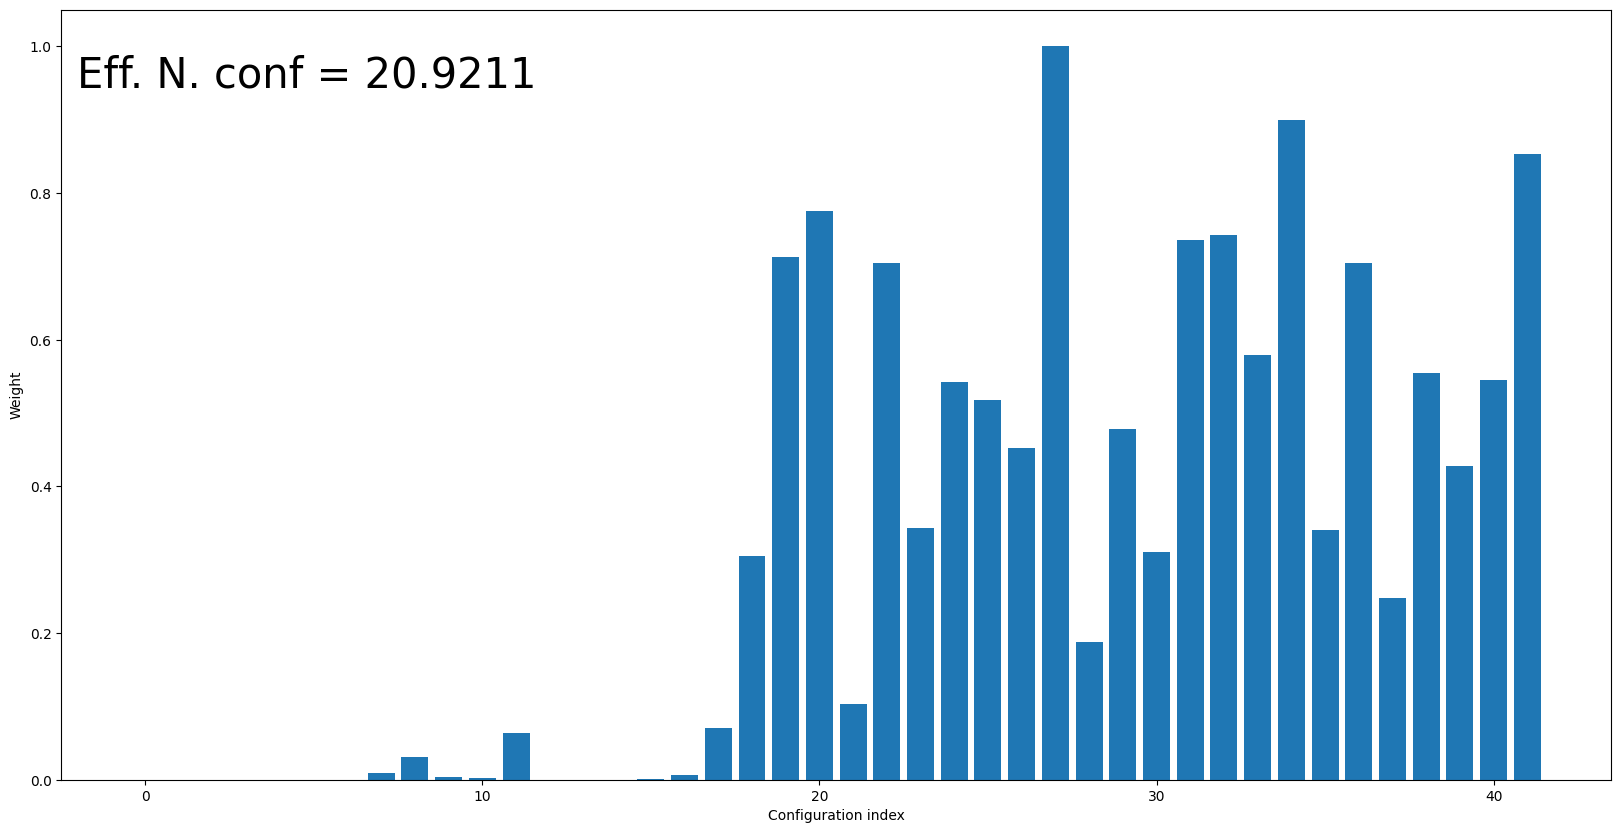

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from mlacs.utilities.plots import plot_weights, init_rcParams

plt.rcParams.update({'figure.figsize': (20,10)})
fig, ax0 = plt.subplots()
init_rcParams()
w = mbar.weight*mbar.get_effective_conf()
w /= max(w)                                  # Just to have weights from 0 to 1
ax0 = plot_weights(ax0, w)
plt.show()

You can also notice the very low RMSE and MAE at the end of the MLACS simulation. This is due to the reweighting.
As an example, we can run a new MLACS simulation without the MBAR weights and compare the results.

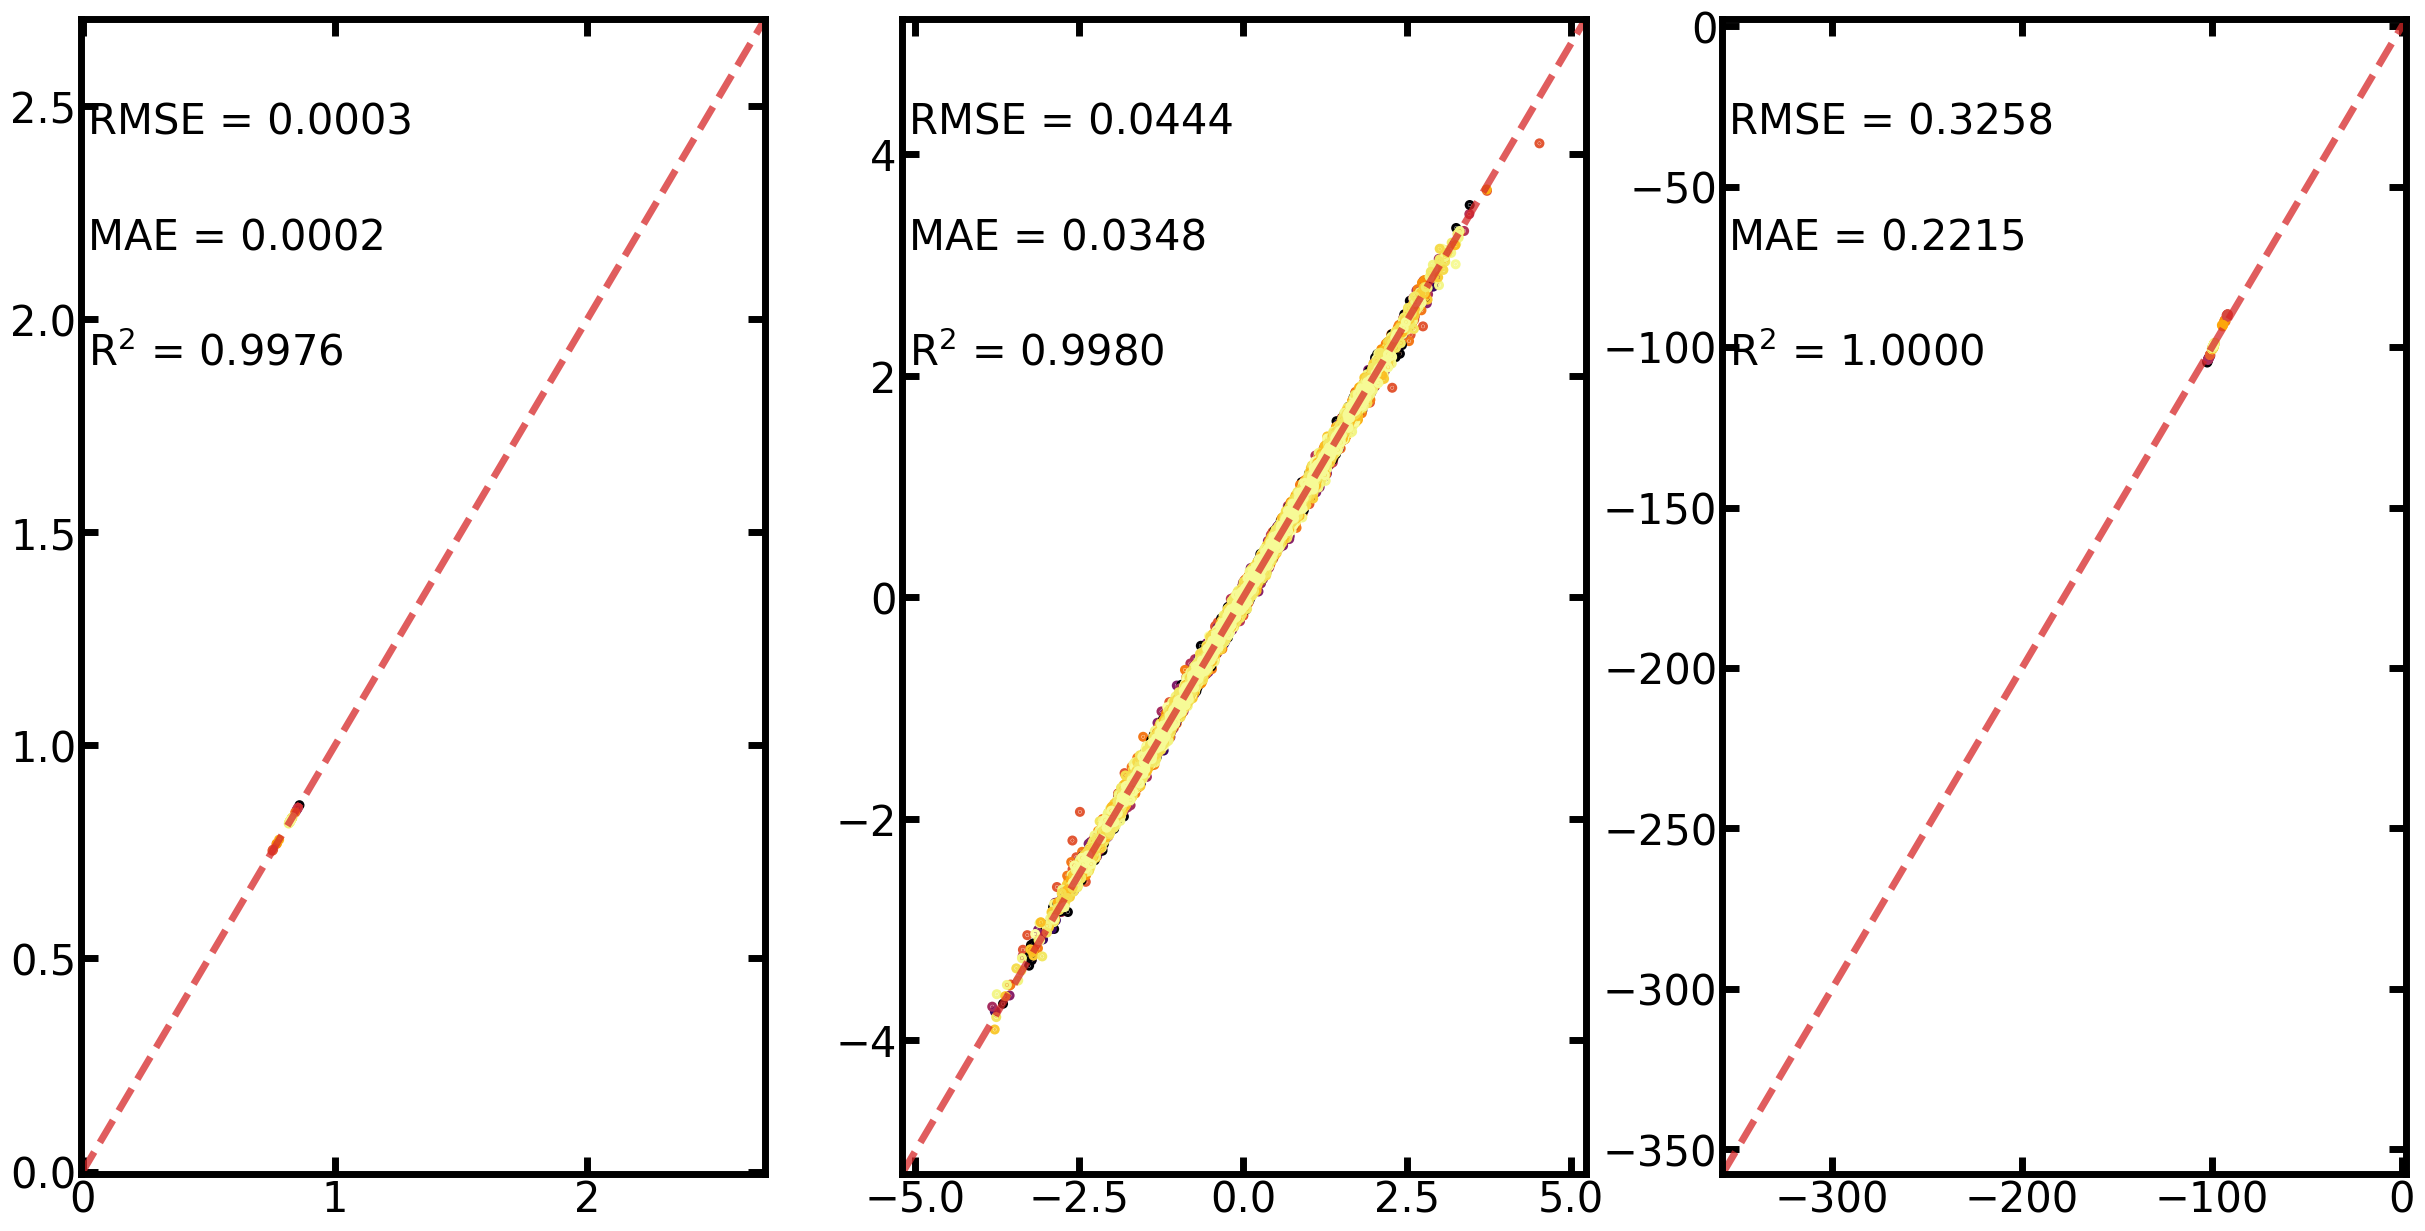

In [38]:
from mlacs.utilities.plots import plot_correlation

e_data = np.loadtxt('Mbar_Trajectory/MLIP-Energy_comparison.dat')
f_data = np.loadtxt('Mbar_Trajectory/MLIP-Forces_comparison.dat')
s_data = np.loadtxt('Mbar_Trajectory/MLIP-Stress_comparison.dat')

plt.rcParams.update({'figure.figsize': (30,15)})
fig, (ax0, ax1, ax2) = plt.subplots(1,3)
ax0 = plot_correlation(ax0, e_data, weight=mbar.weight)
ax1 = plot_correlation(ax1, f_data, weight=mbar.weight)
ax2 = plot_correlation(ax2, s_data, weight=mbar.weight)
plt.show()

error1 = mlip_mbar.fit_res

## Launch the same simulation with Uniform weighting policy

We can run the simulation again with uniform configuration weights (this is the default in MLACS). To do it, we need to redefine the MLIP object without specifying a weighting policy. Then we create a new OtfMlacs object and launch the simulation again ... Time for another coffee ?

In [44]:
mlip_uni = LinearPotential(descriptor)
states = list(LammpsState(temperature, pressure, nsteps=nsteps) for i in range(5))
dyn = OtfMlacs(at,
               states,
               calc,
               mlip_uni,
               workdir='Uniform_Trajectory',
               neq=0)
dyn.run(10)

            On-the-fly Machine-Learning Assisted Canonical Sampling
            *******************************************************

                      Copyright (C) 2022-2024 MLACS group.
                    MLACS comes with ABSOLUTELY NO WARRANTY.
               This package is distributed under the terms of the
                   GNU General Public License, see LICENSE.md
                    or http://www.gnu.org.copyleft/gpl.txt.

                      MLACS is common project of the CEA,
           Université de Liège, Université du Québec à Trois-Rivières
                 and other collaborators, see CONTRIBUTORS.md.
                  Please read ACKNOWLEDGMENTS.md for suggested
                      acknowledgments of the MLACS effort.

version 0.0.13

date: 14-10-2024 16:10:42



                       Recap of the simulation parameters

Recap of the states
*******************
State 1/5 :
NPT dynamics as implemented in LAMMPS
Temperature (in Kelvin)                 400
A 

We can plot the correlation functions of the "uniform" trajectory.

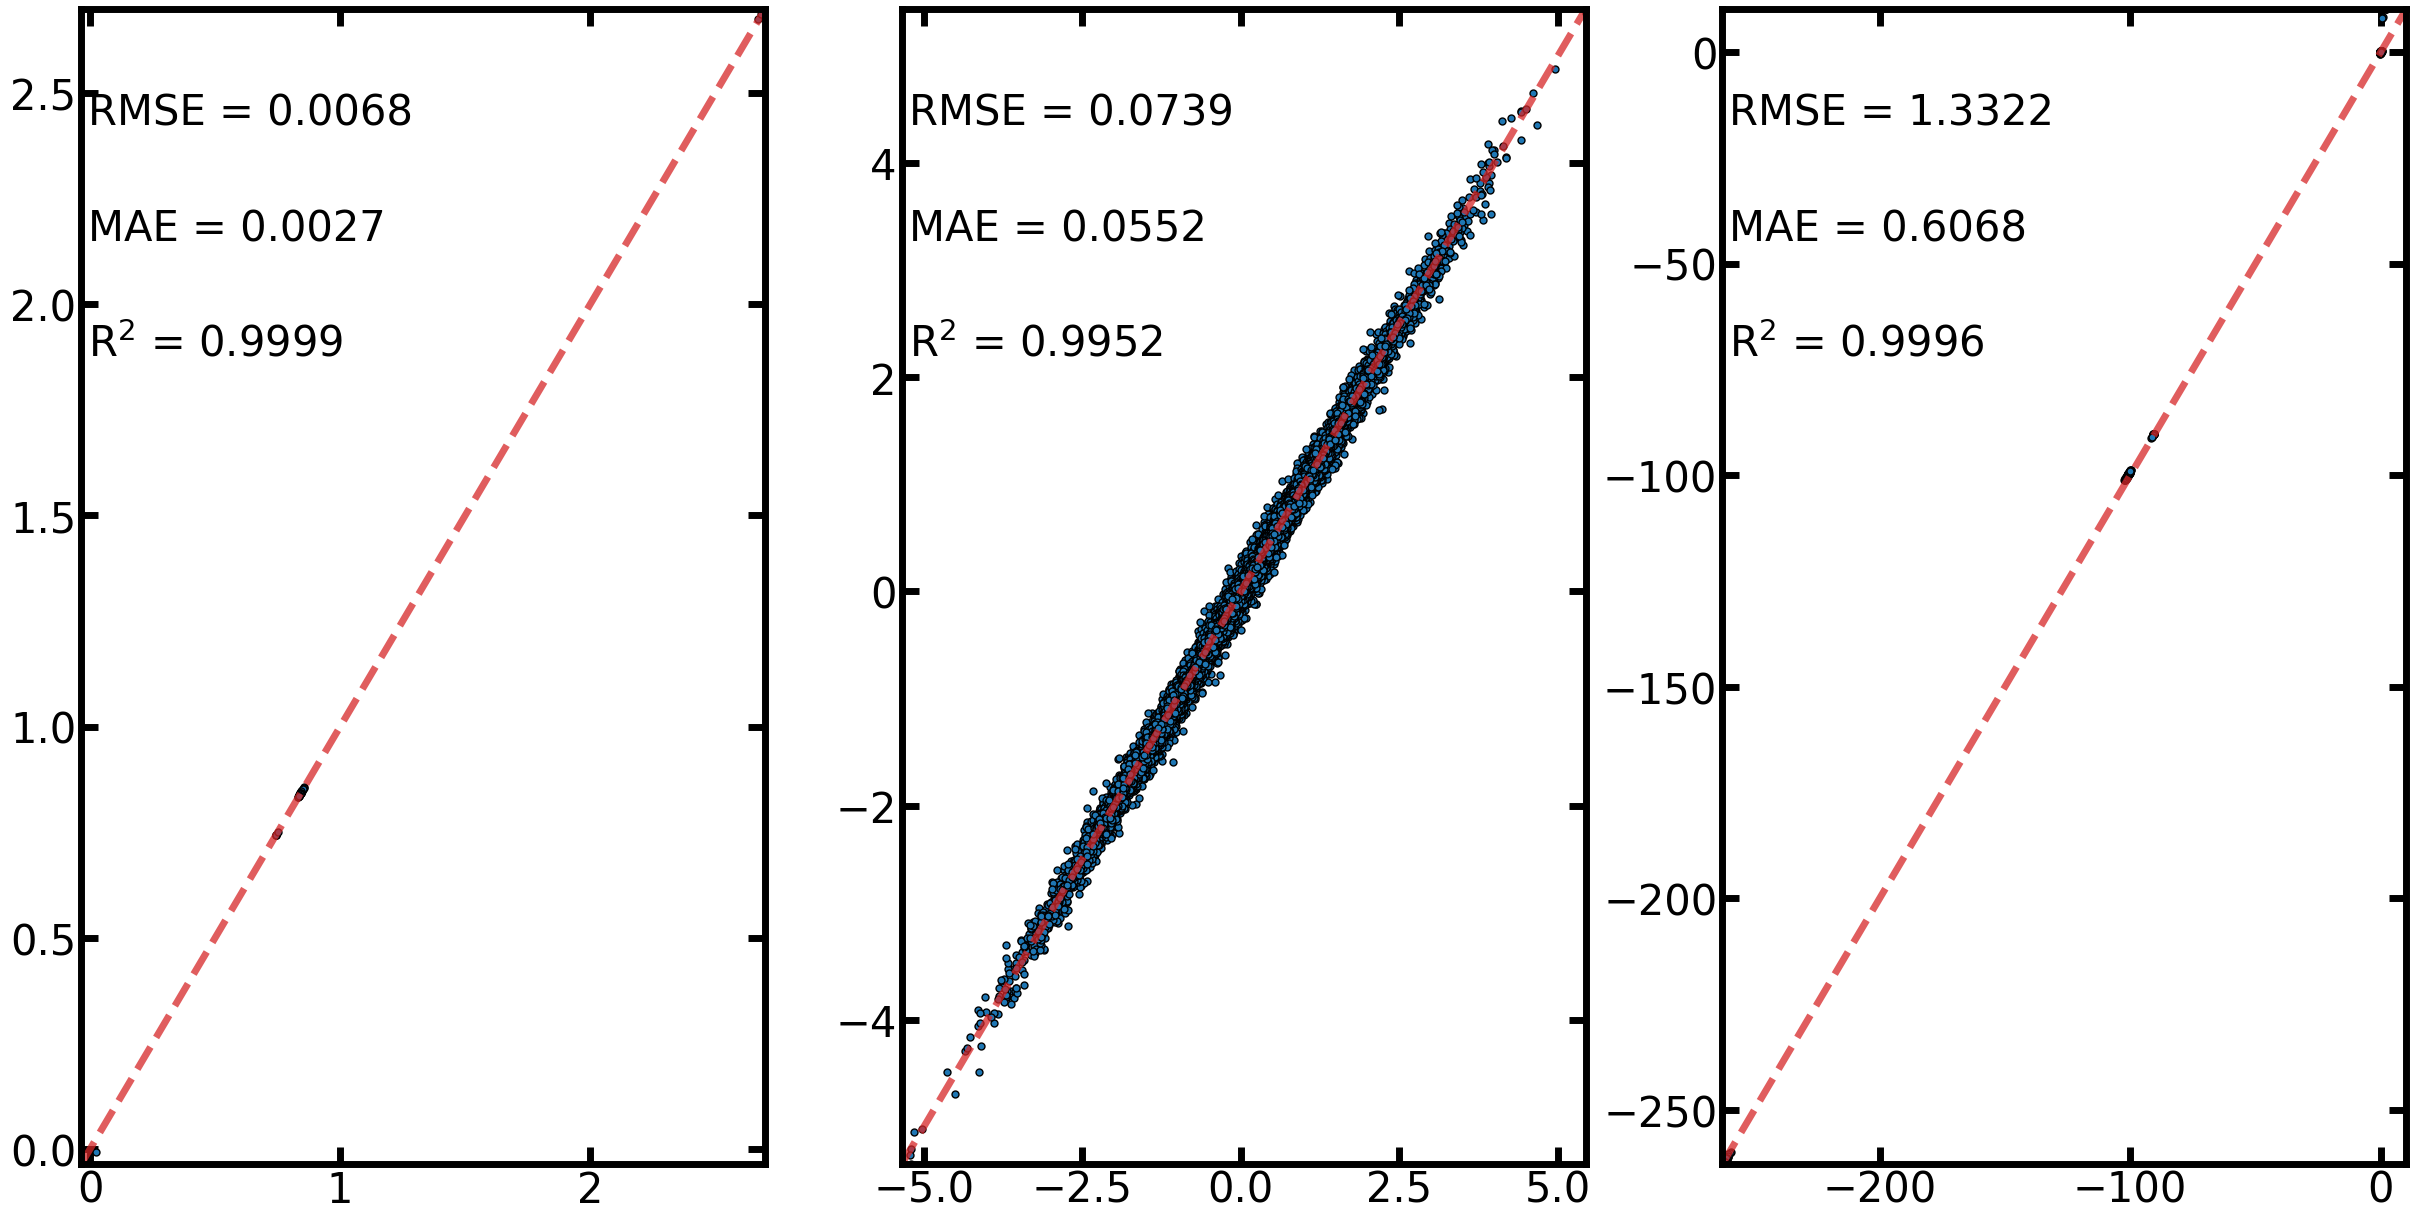

In [45]:
from mlacs.utilities.plots import plot_correlation

e_data = np.loadtxt('Uniform_Trajectory/MLIP-Energy_comparison.dat')
f_data = np.loadtxt('Uniform_Trajectory/MLIP-Forces_comparison.dat')
s_data = np.loadtxt('Uniform_Trajectory/MLIP-Stress_comparison.dat')

plt.rcParams.update({'figure.figsize': (30,15)})
fig, (ax0, ax1, ax2) = plt.subplots(1,3)
ax0 = plot_correlation(ax0, e_data)
ax1 = plot_correlation(ax1, f_data)
ax2 = plot_correlation(ax2, s_data)
plt.show()

error2 = mlip_uni.fit_res

It is clear that the MBAR weighting policy can be very useful, especially when the starting configurations are far from the equilibrium ones. In such cases, the sampled database may not accurately represent the true equilibrium state, which can be problematic when computing representative thermodynamic properties. By using the MBAR weighting policy, we can ensure that the sampled data is properly reweighted to account for any discrepancies between the starting and equilibrium configurations, leading to more accurate and reliable results.

## Replay the simulation with MBAR and the Database Calculator

The final simulation we ran was not in vain, even if it turns out that the resulting database is not representative of the thermodynamic ensemble. In this section, we will explore how we can replay an MLACS simulation without performing any new calculations, and update the database by adding MBAR weights to the sampling configurations. This allows us to make use of the existing data and improve the accuracy of our results without expending additional computational resources.

The DatabaseCalc is a calculator that sequentially reads a previously calculated traj files. We will use it in the present example to replay a MLACS. 

In [48]:
from mlacs.calc import DatabaseCalc

wdir = 'Uniform_Trajectory'
traj = [f'{wdir}/Trajectory_{i}.traj' for i in range(1,6)]
train = f'{wdir}/Training_configurations.traj'
calc = DatabaseCalc(trajfile=traj, trainfile=train)

We also need to update the MLIP object by adding MBAR.

In [49]:
mbar = MbarManager()

mlip_mbar = LinearPotential(descriptor, weight=mbar)
# Dummy states since sampling has already been done.
states = list(LammpsState(temperature, pressure, nsteps=1) for i in range(5))
dyn = OtfMlacs(at,
               states,
               calc,
               mlip_mbar,
               workdir='Replay_Trajectory',
               neq=0)
dyn.run(10)

            On-the-fly Machine-Learning Assisted Canonical Sampling
            *******************************************************

                      Copyright (C) 2022-2024 MLACS group.
                    MLACS comes with ABSOLUTELY NO WARRANTY.
               This package is distributed under the terms of the
                   GNU General Public License, see LICENSE.md
                    or http://www.gnu.org.copyleft/gpl.txt.

                      MLACS is common project of the CEA,
           Université de Liège, Université du Québec à Trois-Rivières
                 and other collaborators, see CONTRIBUTORS.md.
                  Please read ACKNOWLEDGMENTS.md for suggested
                      acknowledgments of the MLACS effort.

version 0.0.13

date: 14-10-2024 16:14:29



                       Recap of the simulation parameters

Recap of the states
*******************
State 1/5 :
NPT dynamics as implemented in LAMMPS
Temperature (in Kelvin)                 400
A 

Computing the average volume
Average structure:
- cell:    5.725472281045664 angs
- vol/atom:    3.938777605417635 angs^3

Computing the average volume
Average structure:
- cell:    5.725815049871249 angs
- vol/atom:    3.939357663642892 angs^3

Computing the average volume
Average structure:
- cell:    5.726162591844242 angs
- vol/atom:    3.939918466527876 angs^3

Step 9

Production step for state 1, configurations 9 for this state
Production step for state 2, configurations 9 for this state
Production step for state 3, configurations 9 for this state
Production step for state 4, configurations 9 for this state
Production step for state 5, configurations 9 for this state


Training new MLIP

Reached a solution to within tolerance with SLSQP
Solution found within tolerance!
Final gradient norm: 2.67e-07

Number of configurations for training: 42
Number of atomic environments for training: 10752

Using MBAR weighting
Effective number of configurations:   21.78641
Number of uncorrelated

We can also plot the weight obtained from the uniform sampling trajectory.

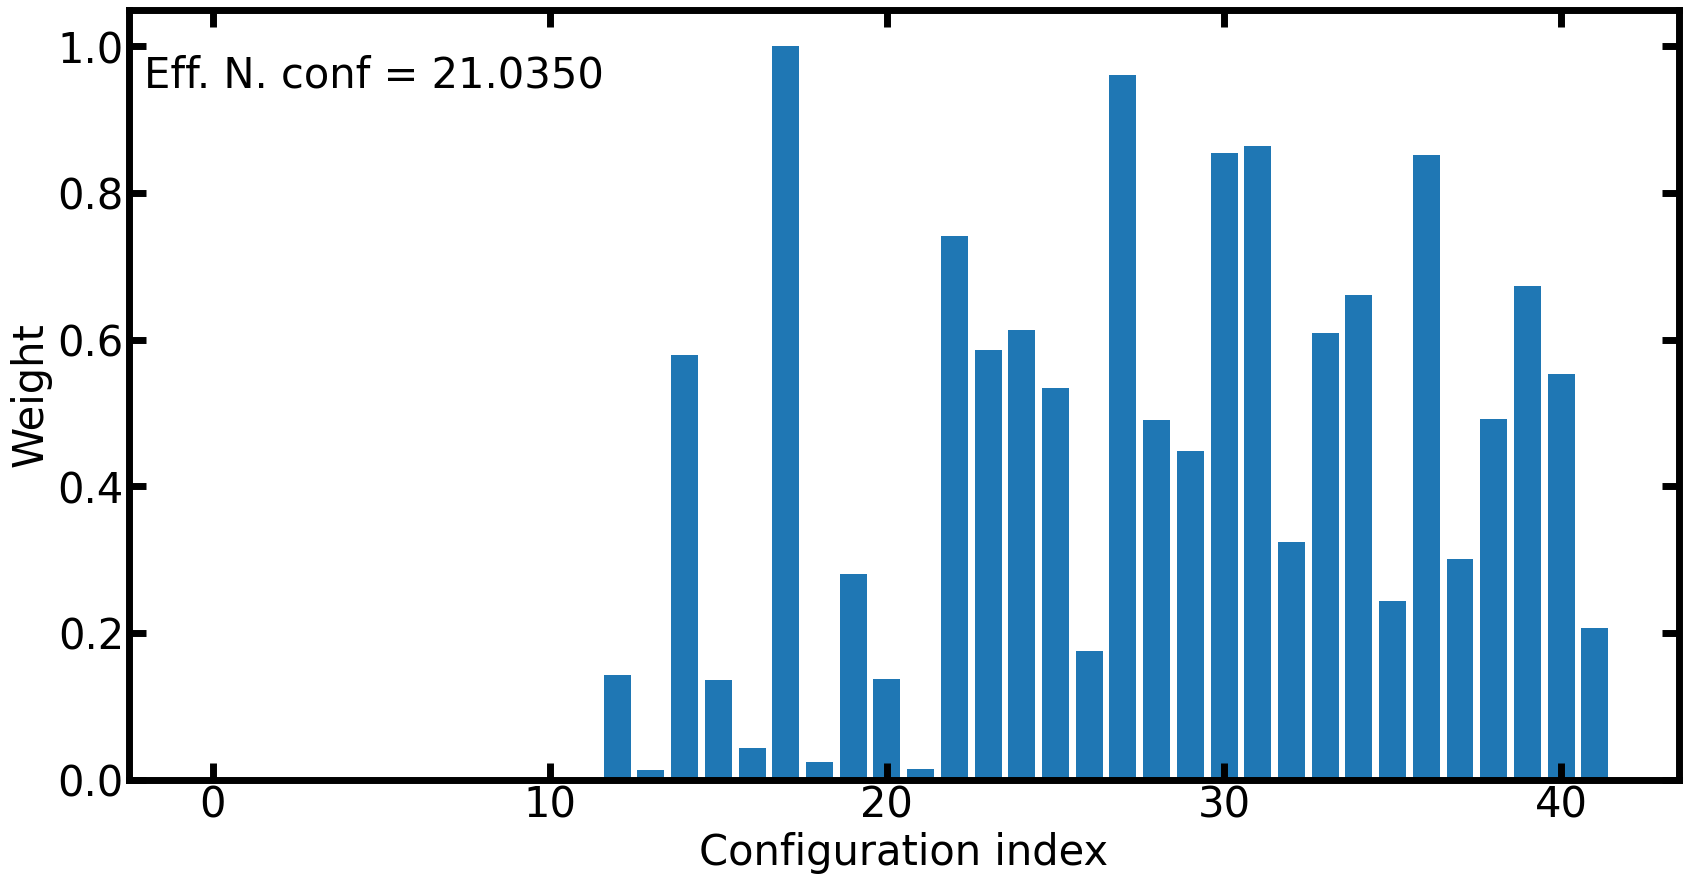

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from mlacs.utilities.plots import plot_weights, init_rcParams

plt.rcParams.update({'figure.figsize': (20,10)})
fig, ax0 = plt.subplots()
init_rcParams()
w = mbar.weight*mbar.get_effective_conf()
w /= max(w)                                  # Just to have weights from 0 to 1
ax0 = plot_weights(ax0, w)
plt.show()

You can see that the weight from the first configurations are zero, meaning that they are very far away from the equilibrium sampled state. 

A new MLIP can be fitted using the MBAR weights obtained from the uniform sampling database. 

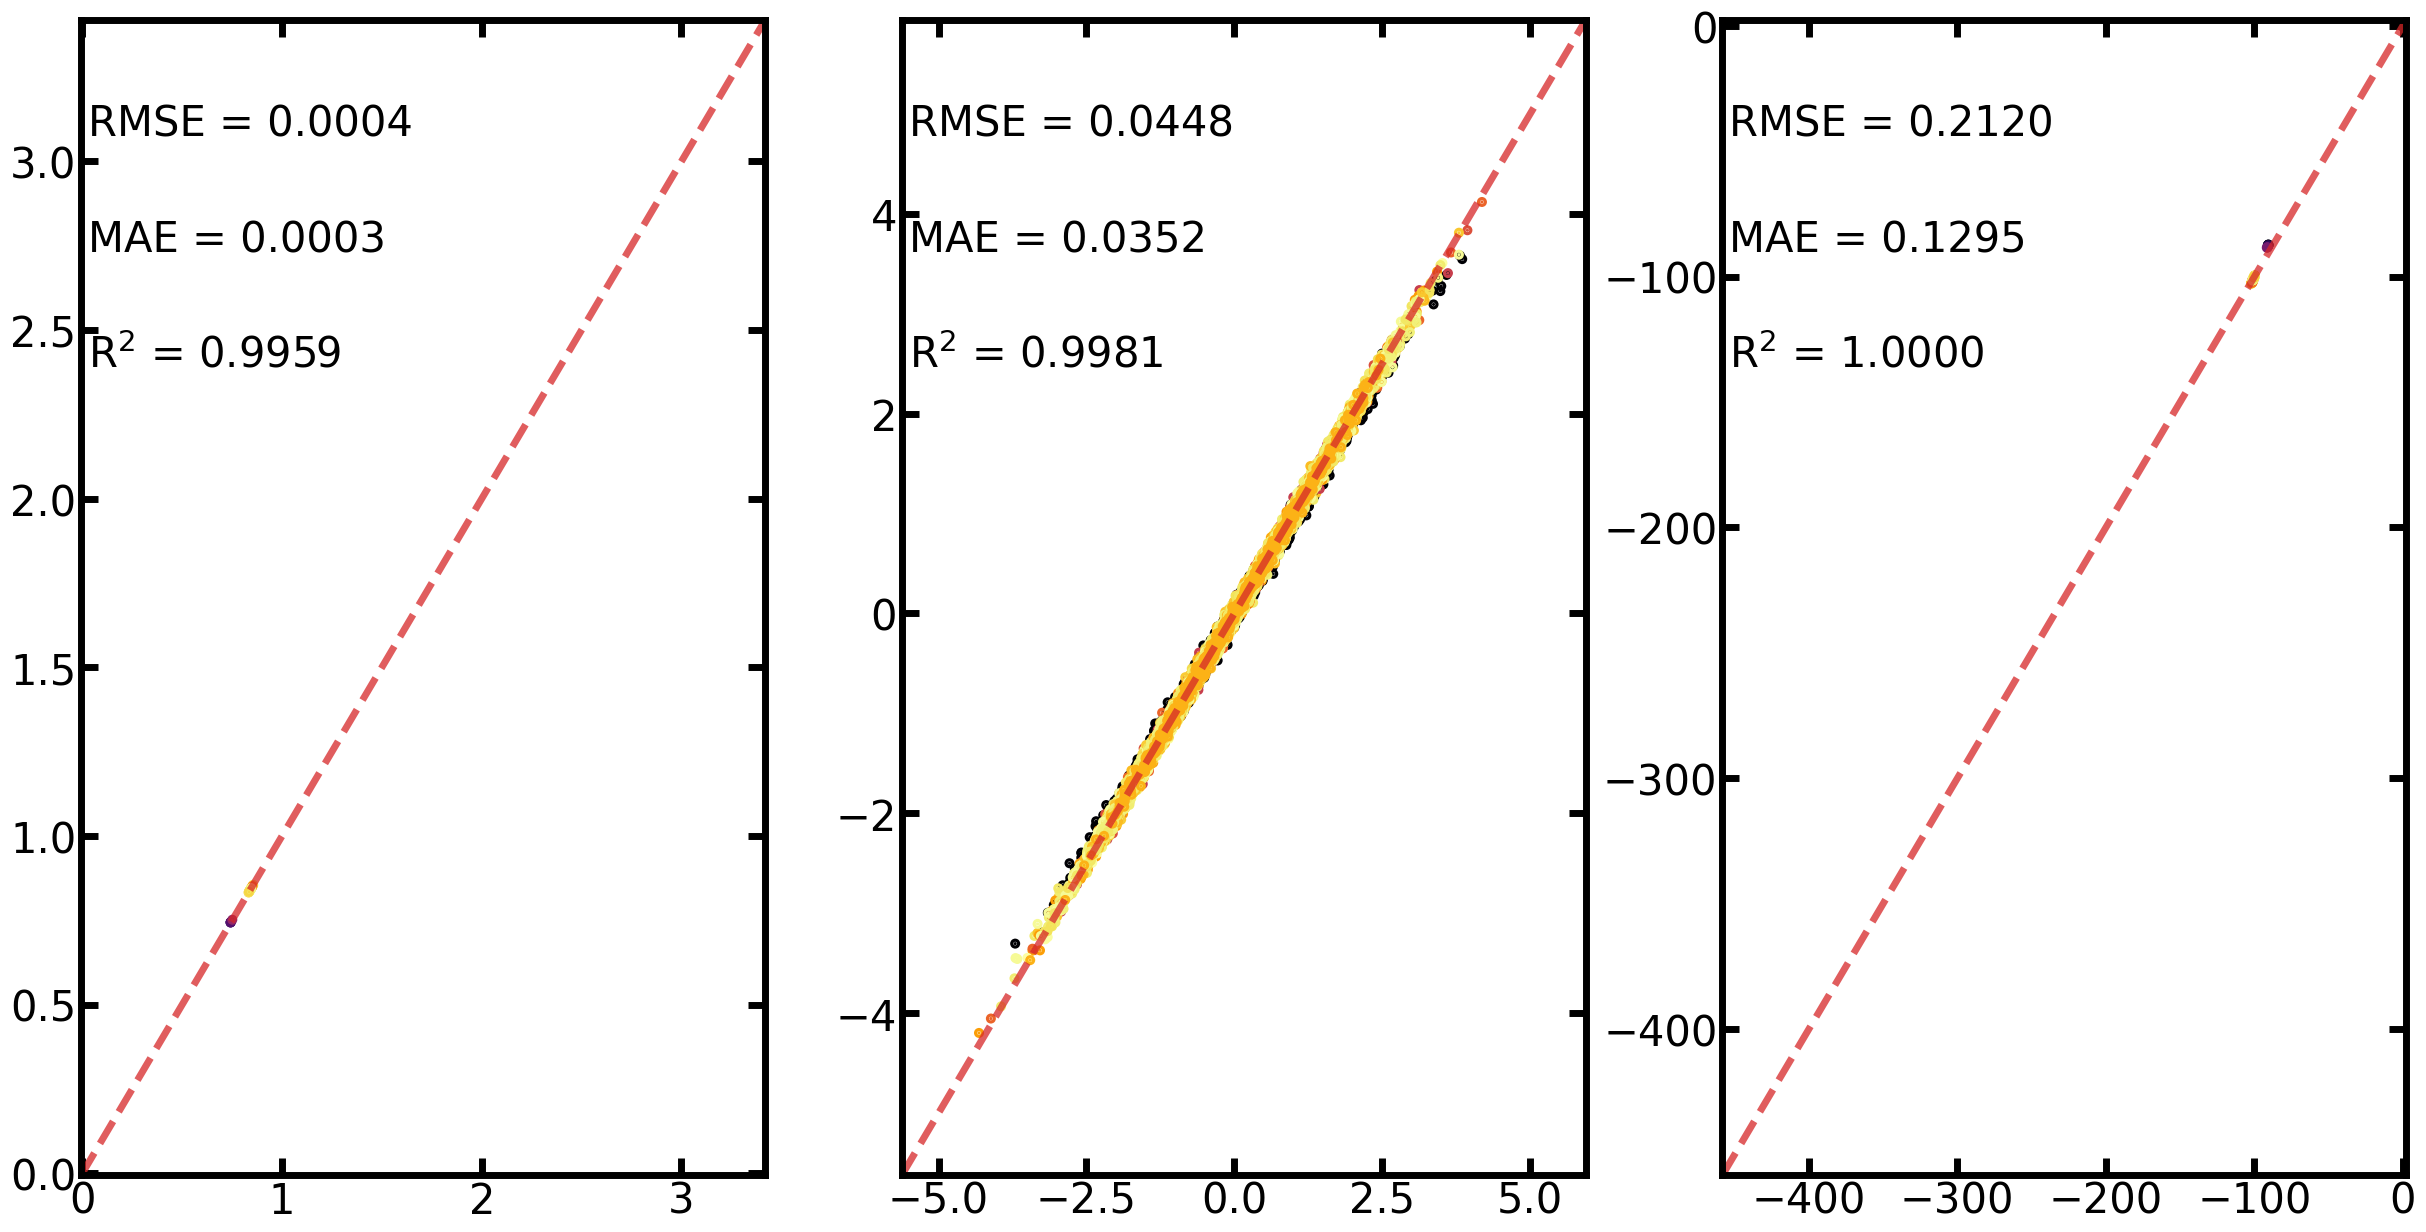

In [52]:
from mlacs.utilities.plots import plot_correlation

e_data = np.loadtxt('Replay_Trajectory/MLIP-Energy_comparison.dat')
f_data = np.loadtxt('Replay_Trajectory/MLIP-Forces_comparison.dat')
s_data = np.loadtxt('Replay_Trajectory/MLIP-Stress_comparison.dat')

plt.rcParams.update({'figure.figsize': (30,15)})
fig, (ax0, ax1, ax2) = plt.subplots(1,3)
ax0 = plot_correlation(ax0, e_data, weight=mbar.weight)
ax1 = plot_correlation(ax1, f_data, weight=mbar.weight)
ax2 = plot_correlation(ax2, s_data, weight=mbar.weight)
plt.show()

error3 = mlip_mbar.fit_res

At the end we can compare the errors from the three different situations:

In [72]:
def results_errors(results):
    txt = f"RMSE Energy       {results[0, 0]*1000:.3f} meV/at\n"
    txt += f"MAE Energy        {results[1, 0]*1000:.3f} meV/at\n"
    txt += f"RMSE Forces       {results[0, 1]:.3f} eV/angs\n"
    txt += f"MAE Forces        {results[1, 1]:.3f} eV/angs\n"
    txt += f"RMSE Stress       {results[0, 2]:.3f} GPa\n"
    txt += f"MAE Stress        {results[1, 2]:.3f} GPa\n"
    return txt
      
txt = 'MLACS sampling with MBAR weights:\n'
txt += '------------------------------------------------\n'
txt += results_errors(error1)
txt += '\n'
txt += 'MLACS sampling with uniform weights:\n'
txt += '------------------------------------------------\n'
txt += results_errors(error2)
txt += '\n'
txt += 'MLACS uniform sampling with MBAR weights:\n'
txt += '------------------------------------------------\n'
txt += results_errors(error3)
print(txt)

MLACS sampling with MBAR weights:
------------------------------------------------
RMSE Energy       0.279 meV/at
MAE Energy        0.245 meV/at
RMSE Forces       0.044 eV/angs
MAE Forces        0.035 eV/angs
RMSE Stress       0.326 GPa
MAE Stress        0.222 GPa
ME Free Energy    0.245 meV/at

MLACS sampling with uniform weights:
------------------------------------------------
RMSE Energy       6.798 meV/at
MAE Energy        2.703 meV/at
RMSE Forces       0.074 eV/angs
MAE Forces        0.055 eV/angs
RMSE Stress       1.332 GPa
MAE Stress        0.607 GPa
ME Free Energy    2.139 meV/at

MLACS uniform sampling with MBAR weights:
------------------------------------------------
RMSE Energy       0.369 meV/at
MAE Energy        0.346 meV/at
RMSE Forces       0.045 eV/angs
MAE Forces        0.035 eV/angs
RMSE Stress       0.212 GPa
MAE Stress        0.129 GPa
ME Free Energy    0.346 meV/at

